<a href="https://colab.research.google.com/github/carinunez/Tareas_generativos/blob/main/Tarea_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tarea 3: Autoencoderes Variacionales

### MDS7203 Modelos Generativos Profundos

**Nombre:**

**Fecha de entrega:**

En esta tercera tarea se implementará un VAE para el dataset de juguete [`3d-shapes`](https://github.com/google-deepmind/3d-shapes). Los objetivos serán implementar una red neuronal acorde al dataset de entrenamiento, entrenar el VAE y estudiar las propiedades semánticas del espacio latente inducido.

Algunas instrucciones generales:

- Se pueden utilizar de manera libre herramientas como ChatGPT y Claude, entre otras.
- Para la entrega, no es necesario un informe, este archivo es suficiente.
- Se debe entregar el documento con todas las celdas ejecutadas.
- La tarea debe ser realizada en Google Colab.

In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Datos de entrenamiento

El dataset `3d-shapes` es un dataset artificial construido a partir de 6 factores latentes claramente definidos ([ver ejemplo](https://github.com/google-deepmind/3d-shapes/blob/master/3dshapes_loading_example.ipynb)):

```
_FACTORS_IN_ORDER = ['floor_hue', 'wall_hue', 'object_hue', 'scale', 'shape', 'orientation']
```

Para la construcción de este dataset se consideraron distintos valores para cada factor latente. La cantidad de valores distintos para cada factor viene dada en el siguiente diccionario:

```
_NUM_VALUES_PER_FACTOR = {
    'floor_hue':   10,
    'wall_hue':    10,
    'object_hue':  10,
    'scale':       8,
    'shape':       4,
    'orientation': 15
    }
```

Lo que da un total de $10\times10\times10\times8\times4\times15=480\,000$ imágenes.

- ¿Qué define cada uno de estos factores latentes? ¿Cuáles son los distintos valores o rangos que pueden tomar estos factores latentes?
> **Respuesta:**
floor_hue representa el color del piso  y toma 10 valores separados linealmente entre 0 y 1
wall_hue corresponde al color de la pared, object_hue=color del objeto (ambos toman 10 valores), scale es el tamaño del objeto con 8 valores entre 0 y 1, shape es la forma del objeto tomando valores discretos enteros entre {0,1,2,3} y orientation (es el ángulo de rotación del objeto) tomando 15 valores equidistantes en el rango entre [-30°.30°]
- Considerando la naturaleza de cada factor latente, ¿qué distribuciones de probabilidad se podrían asociar a cada factor?
> **Respuesta:**
floor_hue toma valores equiespaciados entre 0 y 1, por lo que se podría asociar una distribución uniforme discreta sobre 10 valores, al igual que wall_he y object_hue. Mientras que scale sería una uniforme discreta de 8 valores (entre 0 y 1), por otro lado shape sería una distribución categórica uniforme tomando los valores {0,1,2,3} y orientation sería una uniforme discreta sobre 15 valores.
Las imágenes asociadas a este dataset están contenidas en el [siguiente archivo](https://console.cloud.google.com/storage/browser/3d-shapes;tab=objects?inv=1&invt=Abx13w&prefix=&forceOnObjectsSortingFiltering=false):

In [2]:
!gsutil -m cp gs://3d-shapes/3dshapes.h5 .

Copying gs://3d-shapes/3dshapes.h5...
==> NOTE: You are downloading one or more large file(s), which would
run significantly faster if you enabled sliced object downloads. This
feature is enabled by default but requires that compiled crcmod be
installed (see "gsutil help crcmod").

/ [1/1 files][255.2 MiB/255.2 MiB] 100% Done                                    
Operation completed over 1 objects/255.2 MiB.                                    


In [3]:
f = h5py.File('3dshapes.h5', 'r')
print("Claves del archivo:", list(f.keys()))

# Forma de las imágenes,etiquetas y formato
print("Tamaño de las imágenes:", f['images'].shape)
print("Tamaño de los labels:  ", f['labels'].shape)
print(type(f['labels']))

Claves del archivo: ['images', 'labels']
Tamaño de las imágenes: (480000, 64, 64, 3)
Tamaño de los labels:   (480000, 6)
<class 'h5py._hl.dataset.Dataset'>


### Clase para el dataset

- Implemente la clase `Shapes3D` utilizando el archivo descargado. Si tiene problemas de memoria RAM, puede fijar un parámetro `max_samples` para definir una cantidad máxima de muestras. En este caso, las imágenes seleccionadas para constituir el dataset deben ser elegidas de forma aleatoria sobre las $480\,000$ imágenes que contiene el dataset original.

#este esta malo

In [5]:
class Shapes3D(Dataset):

    def __init__(self, filename, max_samples=None, seed=0):
      # nombre del archivo guardado
       self.filename=filename
      #se abre el archivo en el formato HDF5 para leer 'r'
       self.file=h5py.File(self.filename,'r')

      #se guardan las imagenes y etiquetas
       self._images=self.file['images']
       self._labels=self.file{'labels'}

      #cantidad de imagenes en total
       self.total_samples=len(self._images)

      #indices se sacan de forma aleatoria para tomar muestra, replace= False
      #es que sean distintos
      if max_samples is not None:
        rng=np.random.default_rng(seed) #generador random con semilla
        self.indices=rng.choice(self.total_samples,size=max_samples,replace=False)
        else:
          self.indices=np.arange(self.total_samples)

    def __len__(self):
      return len(self.indices)  #cantidad de indices guardados

    def __getitem__(self, n):
      i=self.indices[n] #se busca el índice

      #capturamos la imagen y su etiqueta asociada
      img=self.images[i].astype(p.float32)/255.0 #normalización
      img=np.transpose(img,(2,0,1)) # se cambia orden de ejes de alto,ancho,canales
      #a canales,alto, ancho
      label=self.latents[i].astype(np.float32)
      return torch.tensor(image),torch.tensor(label)

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 18)

# Codigo bueno

In [6]:
class Shapes3D(Dataset):

    def __init__(self, filename, max_samples=None, seed=0):
        # nombre del archivo guardado
        self.filename = filename
        # se abre el archivo en el formato HDF5 para leer 'r'
        self.file = h5py.File(self.filename, 'r')

        # se guardan las imágenes y etiquetas
        self._images = self.file['images']
        self._labels = self.file['labels']

        # cantidad de imágenes en total
        self.total_samples = len(self._images)

        # índices se sacan de forma aleatoria para tomar muestra
        # replace = False es que sean distintos
        if max_samples is not None:
            rng = np.random.default_rng(seed)  # generador random con semilla
            self.indices = rng.choice(self.total_samples, size=max_samples, replace=False)
        else:
            self.indices = np.arange(self.total_samples)

    def __len__(self):
        return len(self.indices)  # cantidad de índices guardados

    def __getitem__(self, n):
        i = self.indices[n]  # se busca el índice

        # capturamos la imagen y su etiqueta asociada
        img = self._images[i].astype(np.float32) / 255.0  # normalización
        img = np.transpose(img, (2, 0, 1))  # cambia orden de ejes: alto, ancho, canales → canales, alto, ancho
        label = self._labels[i].astype(np.float32)
        return torch.tensor(img), torch.tensor(label)

Con la clase `Shapes3D` implementada, asumiendo que su constructor `__init__` recibe parámetros `filename` (nombre del archivo descargado) y `max_samples` (cantidad de muestras en el dataset), se puede instanciar el dataset y el respectivo dataloader.

- Defina valores para `batch_size` y `max_samples` que sean compatible con el hardware disponible.

In [8]:
dataset = Shapes3D(filename='3dshapes.h5', max_samples=32)

In [9]:
batch_size = 8
max_samples = 32

dataset = Shapes3D(filename='3dshapes.h5', max_samples=max_samples)
dataloader = DataLoader(dataset, batch_size, shuffle=True, num_workers=2, pin_memory=True)

In [10]:
# Ver el primer batch
for images, labels in dataloader:
    print("Tamaño del batch de imágenes:", images.shape)
    print("Tamaño del batch de labels:", labels.shape)
    break  # solo ver el primero

Tamaño del batch de imágenes: torch.Size([8, 3, 64, 64])
Tamaño del batch de labels: torch.Size([8, 6])


In [12]:
for batch_idx, (images, labels) in enumerate(dataloader):
    print(f"⭐ Batch {batch_idx + 1}")
    print("  Tamaño del batch de imágenes:", images.shape)
    print("  Tamaño del batch de labels:  ", labels.shape)

⭐ Batch 1
  Tamaño del batch de imágenes: torch.Size([8, 3, 64, 64])
  Tamaño del batch de labels:   torch.Size([8, 6])
⭐ Batch 2
  Tamaño del batch de imágenes: torch.Size([8, 3, 64, 64])
  Tamaño del batch de labels:   torch.Size([8, 6])
⭐ Batch 3
  Tamaño del batch de imágenes: torch.Size([8, 3, 64, 64])
  Tamaño del batch de labels:   torch.Size([8, 6])
⭐ Batch 4
  Tamaño del batch de imágenes: torch.Size([8, 3, 64, 64])
  Tamaño del batch de labels:   torch.Size([8, 6])


- ¿Qué técnicas de data augmentation se podrían haber usado en este dataset? ¿Qué técnicas serían contraproducentes para el entrenamiento?
> **Respuesta:**
recortes de ciertas partes de la imagen aleatorios, desordenar la imagen para que el modelo aprendiera más texturas aunque sean figuras algo simples, dejar algunas partes en negro, agregar algo de ruido gaussiano.

Las que no servirian serian cambios de color, rotacion, escala, es decir todos los factores latentes que se buscan capturar con el modelo, ya que, estos existen y las imagenes creadas son una combinación de estos factores, por lo que esas transformaciones darían sobreajuste, ya que, sería aprender sobre lo mismo, y como algunos son factores latentes estan distribuidos linealmente sería aún más fácil que aprenda el modelo

### Visualización

La siguiente función auxiliar se usará para visualizar un batch de imágenes genérico:

In [14]:
def show_images(imgs, ncols=None):
    imgs = imgs.permute(0, 2, 3, 1).detach().cpu()
    n_images = imgs.shape[0]
    ncols = ncols or int(n_images**0.5)
    nrows = -(-n_images // ncols)

    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 2, nrows * 2))
    for ax, img in zip(axes.flat, imgs):
        ax.imshow(img)
        ax.axis('off')
    for ax in axes.flat[n_images:]:
        ax.set_visible(False)

    plt.tight_layout()
    plt.show()

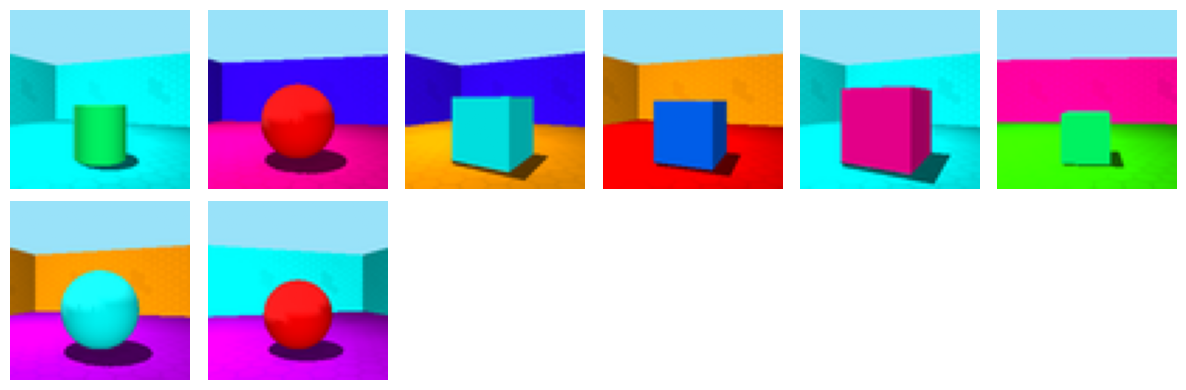

In [15]:
imgs, labels = next(iter(dataloader))
assert imgs.shape == (batch_size, 3, 64, 64)
assert labels.shape == (batch_size, 6)

show_images(imgs[:12], ncols=6)

## Red neuronal y entrenamiento

### Clase `VAE`

- Implemente la siguiente clase asociada a la red neuronal de un **VAE incondicional**. El método `forward` debe retornar el par $(\mu_\theta,\sigma_\theta)\in\mathbb{R}^L\times\mathbb{R}^L_{++}$ asociado al encoder y el tensor $r_\phi\in[0,1]^D$ asociado al decoder (revisar [implementación vista en clases](https://github.com/fernando-fetis/MDS7203/tree/main/Clases/Clase%2013/notebooks)). La red neuronal debe ser una red convolucional acorde a la complejidad del dataset, y puede usar cualquiera de las técnicas vistas durante el curso.

In [ ]:
class VAE(nn.Module):

    def __init__(self, latent_dim):
        super().__init__()
        self.latent_dim = latent_dim
        ...

    def forward(self, x):
        ...
        return (mu, std), x_dec

### Loop de entrenamiento

Como se vio en clases, la ELBO de un VAE está compuesta por un término de reconstrucción y un término regularizador llamado prior matching:

\begin{equation}
\operatorname{ELBO}(x):=\mathbb{E}_{q_\phi(z|x)}\left[\log p_\theta(x|z)\right] - \operatorname{{D}_{KL}}\left(q_\phi(z|x)\| p_\theta(z)\right)
\end{equation}

- ¿Qué diferencia esta función objetivo de la función objetivo usada en un autoencoder clásico? Dé una interpretación para ambos términos de la ELBO e indique cómo influyen en el entrenamiento de un VAE.
> **Respuesta:**

- La forma final del término de reconstrucción $\mathbb{E}_{q_\phi(z|x)}\left[\log p_\theta(x|z)\right]$ depende de la distribución $p_\theta(x|z)$ elegida para el decoder. Indique qué distribución se asume implícitamente si el término de reconstrucción se calcula
  - Usando MSE (i.e., como la distancia $L^1$ entre la reconstrucción y la muestra original).
  > **Respuesta:**
  - Usando BCE (i.e., usando la entropía cruzada binaria entre la reconstrucción y la muestra original).
  > **Respuesta:**
  - Usando la distancia $L^1$ entre la reconstrucción y la muestra original.
  > **Respuesta:**

- Complete la función `train_vae` que permite entrenar un VAE sobre un dataset de imágenes. Esta función debe contener las siguientes características:
  - Permitir usar distintas métricas para el cálculo del término de reconstrucción. Esto se indica en el parámetro `reconstruction_metric`.
  - Permitir disentangled representations usando la técnica propuesta en $\beta$-VAE ([Higgins et al., 2017](https://openreview.net/forum?id=Sy2fzU9gl)). Esto se indica en el parámetro `beta`.

In [ ]:
def train_vae(model, dataloader, optimizer, reconstruction_metric, beta, n_epochs):

    model = model.to(DEVICE)
    model.train()

    total_steps = n_epochs * len(dataloader)
    global_bar = tqdm(total=total_steps, desc='Entrenamiento', position=0)

    reconstruction_log, prior_matching_log = [], []

    try:
        for epoch in range(1, n_epochs + 1):
            total_reconstruction, total_prior_matching = 0, 0

            for x, _ in dataloader:
                x = x.to(DEVICE)

                # Entrenamiento ------------------------------------------------

                ...

                # Registro -----------------------------------------------------

                total_reconstruction += reconstruction.item()
                total_prior_matching += prior_matching.item()

                global_bar.update(1)
                global_bar.set_postfix({
                    'época': epoch,
                    'reconstrucción': total_reconstruction / len(dataloader.dataset),
                    'prior matching': total_prior_matching / len(dataloader.dataset)
                })

            N = len(dataloader.dataset)
            reconstruction_log.append(total_reconstruction / N)
            prior_matching_log.append(total_prior_matching / N)

    except KeyboardInterrupt:
        print('Entrenamiento interrumpido.')

    finally:
        global_bar.close()

        # Gráfico --------------------------------------------------------------

        fig, ax1 = plt.subplots(figsize=(10, 4))

        ax1.set_xlabel('Época')
        ax1.set_ylabel('', color='red')
        l1, = ax1.plot(reconstruction_log, label='Término de reconstrucción', color='red')
        ax1.tick_params(axis='y', labelcolor='red')

        ax2 = ax1.twinx()
        ax2.set_ylabel('', color='blue')
        l2, = ax2.plot(prior_matching_log, label='Prior matching', color='blue')
        ax2.tick_params(axis='y', labelcolor='blue')

        lines = [l1, l2]
        labels = [line.get_label() for line in lines]
        ax1.legend(lines, labels)

        plt.title('Dinámica de entrenamiento')
        fig.tight_layout()
        plt.show()

Con todo lo anterior bien definido, se puede entrenar el VAE sobre el dataset `Shapes3D`.

- Asigne valores a los hiperparámetros necesarios y entrene el modelo. Justifique su elección para los valores de `latent_dim`, `reconstruction_metric` y `beta`.

> **Respuesta:**

In [ ]:
latent_dim = ...
reconstruction_metric = ...
beta = ...
n_epochs = ...

model = VAE(latent_dim)
optimizer = torch.optim.Adam(model.parameters())

train_vae(model, dataloader, optimizer, reconstruction_metric, beta, n_epochs)

## Tareas de generación

En esta última parte se pide implementar algunas funciones simples para evaluar el entrenamiento del VAE.

### Reconstrucción

- Implemente la función `reconstruction` que retorne la reconstrucción que realiza el VAE sobre una imagen.

In [ ]:
def reconstruction(x, model):
    ...

In [ ]:
imgs, _ = next(iter(dataloader))

x_original = imgs[:6]
x_reconstruction = reconstruction(x_original, model)

show_images(torch.cat([x_original, x_reconstruction], dim=0), ncols=len(x_original))

### Generación de nuevas muestras


- Implemente la función `generate_samples` que genere muestras nuevas a partir del VAE.

In [ ]:
def generate_samples(model, n_samples):
    ...

In [ ]:
samples = generate_samples(model, n_samples=16)
show_images(samples)

### Interpolación

El objetivo de esta pregunta es ver la diferencia entre una interpolación en el espacio de pixeles y el espacio latente inducido por el VAE.

#### Interpolación en el espacio de pixeles

- Implemente la función `interpolate_pixels` que interpole linealmente 2 imágenes. Notar que esta función no hace uso del VAE.

In [ ]:
def interpolate_pixels(x1, x2, steps=8):
    ...

In [ ]:
imgs, _ = next(iter(dataloader))

x1, x2 = imgs[0:2]
pixel_interpolation = interpolate_pixels(x1, x2, steps=8)

show_images(pixel_interpolation, ncols=len(pixel_interpolation))

#### Interpolación en el espacio latente

- Implemente la función `interpolate_latents` que interpole 2 imágenes en el espacio latente del VAE entrenado.

In [ ]:
def interpolate_latents(x1, x2, model, steps=8):
    ...

In [ ]:
imgs, _ = next(iter(dataloader))

# Se interpolan las mismas imágenes usadas en interpolate_pixels:
pixel_interpolation = interpolate_latents(x1, x2, model)

show_images(pixel_interpolation, ncols=len(pixel_interpolation))

### Aritmética en el espacio latente

El objetivo de esta pregunta es realizar aritmética de atributos, donde los atributos, en este caso, vienen dados en la lista `_FACTORS_IN_ORDER` definida al comienzo.

Recordar que, para un atributo dado, se puede calcular un centroide de dicho atributo, $z_{\text{atributo}}\in\mathbb{R}^L$, promediando representaciones latentes de muestras que posean dicho atributo. Con esto, restando los centroides de dos atributos diferentes se obtiene un vector latente director, $z_{\text{director}}\in\mathbb{R}^L$, el cual puede usarse para modificar atributos de una muestra $x\in\mathbb{R}^D$ mediante $x_\lambda = \text{decoder}(\text{encoder}(x)+\lambda z_\text{director})$, donde $\lambda>0$ es un parámetro de traslación.

- Implemente la función `attribute_arithmetic`, la cual recibe 2 diccionarios (`source_attributes` y `target_attributes`) con los atributos que se usarán para definir el vector director. Este vector debe ser aplicado a una imagen dada (`test_img`) usando los ponderadores definidos en la lista `ponderators`.

In [ ]:
def attribute_arithmetic(model, dataset, source_attributes, target_attributes, test_img, ponderators):
    ...

In [ ]:
# Imagen de prueba:
test_img, test_label = dataset[2]
ponderators = torch.linspace(0, 1, 8).tolist()

# Transformar forma original (cubo) -> esfera:
source_attributes = {'shape': test_label[4]}
target_attributes = {'shape': 2}

displaced_img = attribute_arithmetic(model, dataset, source_attributes, target_attributes, test_img, ponderators)

show_images(displaced_img, ncols=len(displaced_img))